In [1]:
#imports

import numpy as np
import matplotlib.pyplot as plt
import glob
from os import path

In [2]:
#data
#placeholder
data = [0.6, 0.5, 0.7]

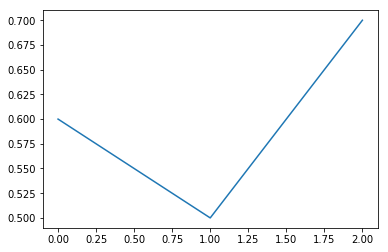

In [3]:
plt.plot(data)
plt.show()

In [4]:
def metis_partition_file_converter(inp, out):
    import sys

    #inp = sys.argv[1]
    #out = sys.argv[2]

    partitions = {}

    def add(el, idx):
        if idx not in partitions:
            partitions[idx] = [el]
        else:
            partitions[idx].append(el)


    with open(inp, "r+") as f:
        el = 0
        for line in f:
            idx = int(line.strip())
            add(el, idx)
            el += 1

    with open(out, "w+") as f:
        idxs = list(partitions.keys())
        idxs.sort()
        assert(idxs[0] <= idxs[-1])
        for ix in idxs:
            f.write(" ".join([str(e) for e in partitions[ix]]) + "\n")

In [5]:
#!for graph in graphs/*.graph; do echo "time start"; time timeout 5m ./a.out  --G_phi=0.05 --H_phi=0.4 --vol=1 --h_ratio=0. -f $graph | tee "$graph.out" ; echo "time end"; done
#!SHELL=/bin/bash

for graph in [glob.glob("graphs/*")[1]]:
    print(graph)

    #run decomposition on all graphs with time limit
    out_path = graph + ".out"
    !time -p timeout 3m ./a.out  --G_phi=0.025 --H_phi=0.4 --vol=1 --h_ratio=0. -f $graph > "$out_path"

    #TODO return code
    if not glob.glob(graph + "cut.txt"):
        print("decomp on", graph, "did not finish in time")
        continue

    #how many clusters, k, did we get?
    with open(out_path) as f:
        lns = f.readlines()
        cluster_line = next(l for l in lns if "n clusters" in l)
        cluster_line.strip("\n")
        n_clusters = int(cluster_line.split(";")[1])

    #run metis on k
    metis_stdio_path = graph + ".out.metis"
    !/usr/local/bin/gpmetis -ufactor=1000 $graph $n_clusters -contig >  $metis_stdio_path

    metis_file = graph + ".part." + str(n_clusters)
    decomp_file = graph + "cut.txt"
    
    metis_partition_file_converter(metis_file, metis_file)

    rw_graph      = graph + ".row_whole"
    rw_file_ours  = graph + ".rw_ours"
    rw_file_metis = graph + ".rw_metis"

    !./a.out  --G_phi=0.025 --H_phi=0.4 --vol=1 --h_ratio=0. -f "$graph" --only_test_expander  > "$rw_graph"
    !./a.out  --G_phi=0.025 --H_phi=0.4 --vol=1 --h_ratio=0. -f "$graph" --only_test_expander -p "$decomp_file" > "$rw_file_ours"
    !./a.out  --G_phi=0.025 --H_phi=0.4 --vol=1 --h_ratio=0. -f "$graph" --only_test_expander -p "$metis_file"  > "$rw_file_metis"
 
    bname = os.path.basename(graph).split(".")[0]
    !mkdir -p results/"$bname"
    for f in glob.glob("".join(graph.split(".")[:-1]) + "*"):
        if f != graph:
            !mv $f results/"$bname"/




graphs/cs4.graph
real 63.17
user 118.45
sys 0.31


In [36]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

n = 3
matrix = [[1, 1, 0], [0, 1, 1], [1, 0, 1]]
matrix = np.array(matrix)

uniform = [ 1/n for _ in range(n)]
uniform = np.array(uniform)

walk    = [1] + [0 for _ in range(n - 1)]
walk    = np.array(walk)

matrix = normalize(matrix, axis=1, norm='l1')


distance = pairwise_distances((matrix @ walk).reshape(-1, 1), uniform.reshape(-1, 1))
distance = pairwise_distances((matrix @ (matrix @ (matrix @ walk))).reshape(-1, 1), uniform.reshape(-1, 1))
print(np.sum(distance))




[0.3125 0.375  0.3125]
0.4999999999999996
